# SIGNED NETWORKS - COMPREHENSIVE TUTORIAL

A hands-on guide to analyzing signed networks using NetworkX

## Topics Covered:
1. Creating and Visualizing Signed Networks
2. Balance Theory and Balance Index
3. Centrality Measures in Signed Networks
4. Community Detection
5. Link Prediction

**Author:** C. Sonnet and H. Pirim


In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')


## PART 1: CREATING AND VISUALIZING SIGNED NETWORKS

Signed networks are graphs where edges have positive (+1) or negative (-1) weights, representing different types of relationships:
- **Positive edges**: friendship, cooperation, support, trust
- **Negative edges**: enmity, competition, opposition, distrust

This dual nature allows us to model complex social dynamics that unsigned networks cannot capture.


In [14]:
def create_signed_network():
    """
    Create a sample signed network with positive and negative edges
    """
    G = nx.Graph()
    
    # Add nodes
    nodes = ['Alice', 'Bob', 'Carol', 'David', 'Eve', 'Frank']
    G.add_nodes_from(nodes)
    
    # Add positive edges (friends)
    positive_edges = [
        ('Alice', 'Bob'), ('Alice', 'Carol'),
        ('Bob', 'David'), ('Carol', 'David'),
        ('Eve', 'Frank')
    ]
    
    # Add negative edges (enemies)
    negative_edges = [
        ('Alice', 'Eve'), ('Bob', 'Frank'),
        ('Carol', 'Frank'), ('David', 'Eve')
    ]
    
    # Add edges with sign attribute
    for edge in positive_edges:
        G.add_edge(edge[0], edge[1], sign=1, relation='friend')
    
    for edge in negative_edges:
        G.add_edge(edge[0], edge[1], sign=-1, relation='enemy')
    
    return G

def visualize_signed_network(G, title="Signed Network"):
    """
    Visualize a signed network with different colors for positive/negative edges
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Separate positive and negative edges
    positive_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == 1]
    negative_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('sign', 1) == -1]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=2000, alpha=0.9)
    
    # Draw positive edges (solid green)
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges,
                          edge_color='green', width=3, alpha=0.7)
    
    # Draw negative edges (dashed red)
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges,
                          edge_color='red', width=3, alpha=0.7,
                          style='dashed')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_centrality(G, centrality_dict, title="Node Centrality"):
    """Visualize network with node sizes based on centrality"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Node sizes based on centrality (handle negative values)
    min_val = min(centrality_dict.values())
    max_val = max(centrality_dict.values())
    if min_val < 0:
        # Normalize to [0, 1] range
        norm_centrality = {n: (centrality_dict[n] - min_val) / (max_val - min_val) if max_val != min_val else 0.5 
                          for n in G.nodes()}
    else:
        norm_centrality = centrality_dict
    
    node_sizes = [norm_centrality[node] * 2000 + 500 for node in G.nodes()]
    
    # Separate edges
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==1]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==-1]
    
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', 
                          node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges, 
                          edge_color='green', width=2)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, style='dashed')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Network created with 6 nodes and 9 edges
Positive edges: 5
Negative edges: 4


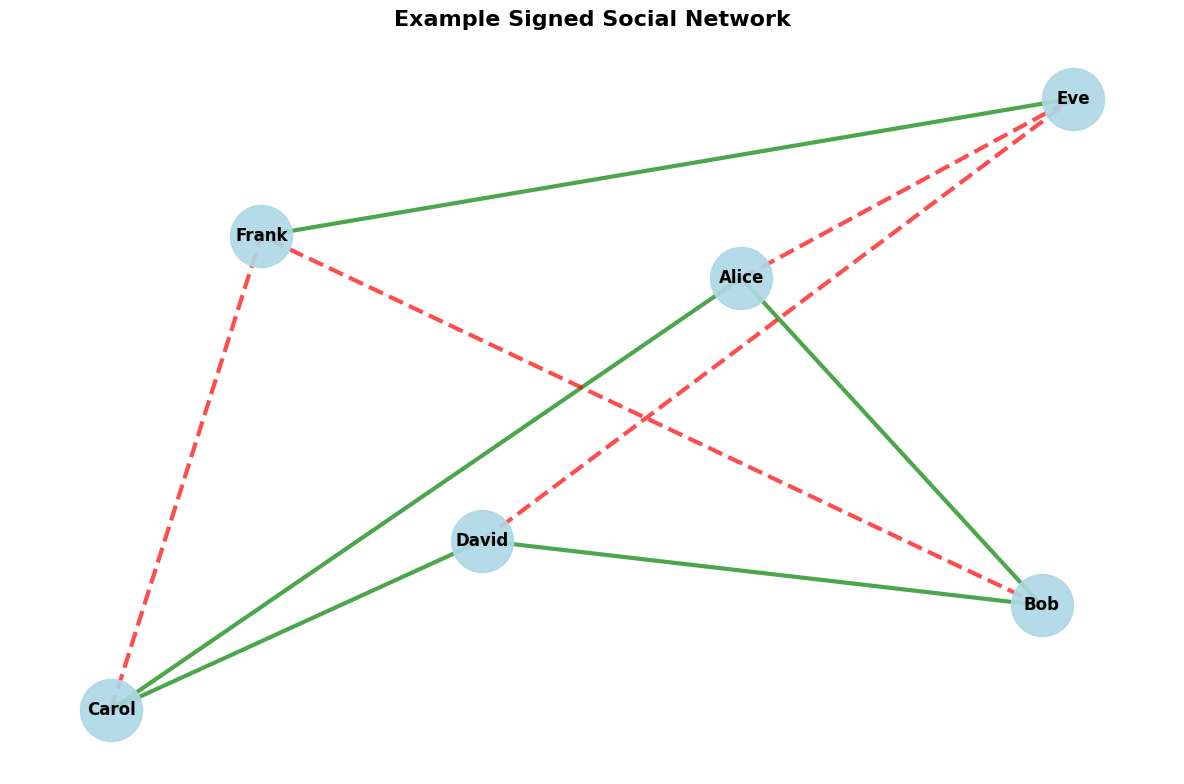

In [15]:
# Create and visualize a signed network
G = create_signed_network()
print(f"Network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
print(f"Positive edges: {len([(u,v) for u,v,d in G.edges(data=True) if d['sign']==1])}")
print(f"Negative edges: {len([(u,v) for u,v,d in G.edges(data=True) if d['sign']==-1])}")

visualize_signed_network(G, "Example Signed Social Network")


## PART 2: BALANCE THEORY AND BALANCE INDEX

**Balance Theory** (Heider, 1946) is a fundamental concept in signed networks:

### Key Principle:
A triangle is **balanced** if the product of its edge signs is positive:
- **Balanced triangles** (product = +1):
  - `(+)(+)(+)`: All friends (stable)
  - `(+)(−)(−)`: "Enemy of my enemy is my friend" (stable)
  
- **Unbalanced triangles** (product = −1):
  - `(+)(+)(−)`: "Friend of my enemy" (unstable)
  - `(−)(−)(−)`: Three mutual enemies (unstable)

### Balance Index:
**Balance Index** = (Number of balanced triangles) / (Total triangles)

A network with high balance index tends toward stability.


In [16]:
def get_triangle_sign(G, triangle):
    """
    Calculate the sign of a triangle (product of edge signs)
    Returns: 1 (balanced) or -1 (unbalanced)
    """
    nodes = list(triangle)
    
    # Get signs of the three edges
    sign1 = G[nodes[0]][nodes[1]]['sign']
    sign2 = G[nodes[1]][nodes[2]]['sign']
    sign3 = G[nodes[2]][nodes[0]]['sign']
    
    # Product of signs
    return sign1 * sign2 * sign3

def calculate_balance_index(G):
    """
    Calculate the balance index of a signed network
    Balance Index = (Number of balanced triangles) / (Total triangles)
    """
    triangles = [clique for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    
    if len(triangles) == 0:
        return 0.0, [], []
    
    balanced_triangles = []
    unbalanced_triangles = []
    
    for triangle in triangles:
        sign = get_triangle_sign(G, triangle)
        if sign == 1:
            balanced_triangles.append(triangle)
        else:
            unbalanced_triangles.append(triangle)
    
    balance_index = len(balanced_triangles) / len(triangles)
    
    return balance_index, balanced_triangles, unbalanced_triangles

def analyze_triangle_types(G, balanced, unbalanced):
    """
    Categorize triangles by their edge sign patterns
    """
    def get_pattern(G, triangle):
        nodes = list(triangle)
        signs = [
            G[nodes[0]][nodes[1]]['sign'],
            G[nodes[1]][nodes[2]]['sign'],
            G[nodes[2]][nodes[0]]['sign']
        ]
        pos_count = sum(1 for s in signs if s == 1)
        return f"{pos_count}+ {3-pos_count}-"
    
    print("\n--- BALANCED TRIANGLES ---")
    for tri in balanced:
        pattern = get_pattern(G, tri)
        print(f"  {tri}: {pattern}")
    
    print("\n--- UNBALANCED TRIANGLES ---")
    for tri in unbalanced:
        pattern = get_pattern(G, tri)
        print(f"  {tri}: {pattern}")


In [17]:
balance_idx, balanced, unbalanced = calculate_balance_index(G)

print(f"Balance Index: {balance_idx:.3f}")
print(f"Balanced triangles: {len(balanced)}")
print(f"Unbalanced triangles: {len(unbalanced)}")

analyze_triangle_types(G, balanced, unbalanced)


Balance Index: 0.000
Balanced triangles: 0
Unbalanced triangles: 0

--- BALANCED TRIANGLES ---

--- UNBALANCED TRIANGLES ---




Balanced Network - Balance Index: 1.000


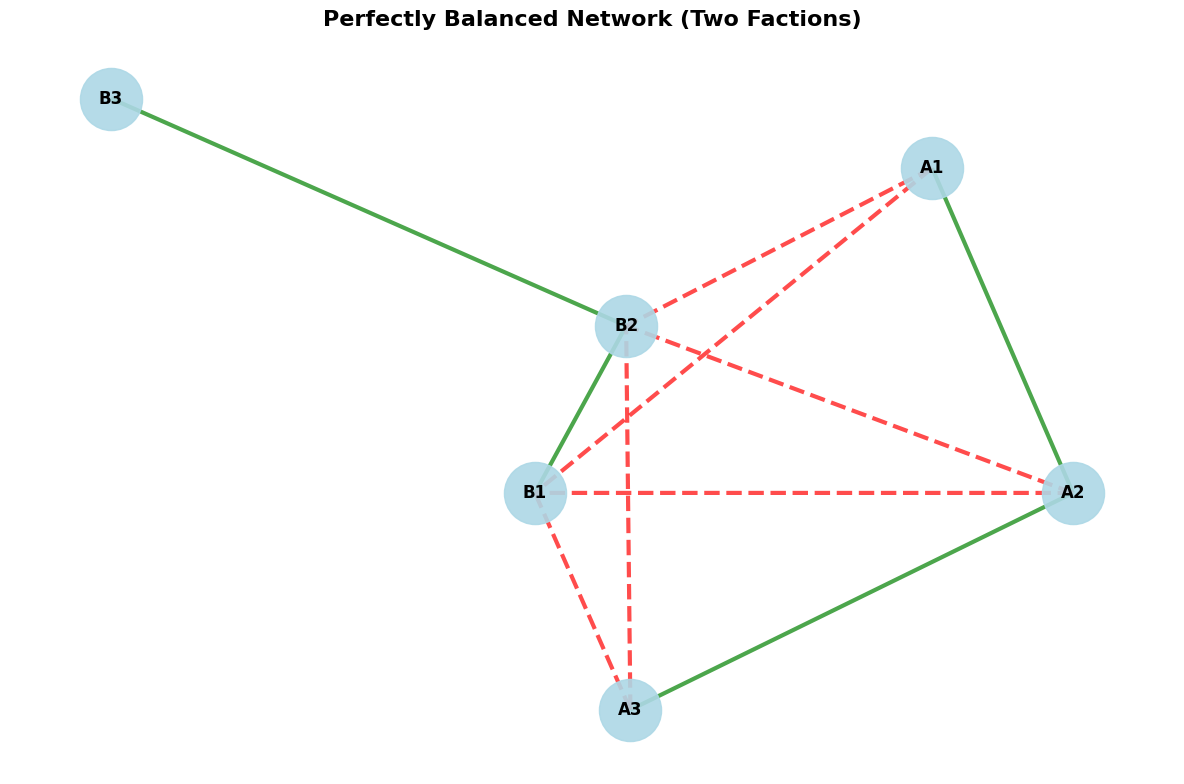

In [18]:
# Create a perfectly balanced network for comparison
def create_balanced_network():
    """Create a perfectly balanced network with two factions"""
    G_balanced = nx.Graph()
    
    # Faction 1
    faction1 = ['A1', 'A2', 'A3']
    # Faction 2
    faction2 = ['B1', 'B2', 'B3']
    
    # Positive edges within factions
    for i in range(len(faction1)-1):
        G_balanced.add_edge(faction1[i], faction1[i+1], sign=1)
    for i in range(len(faction2)-1):
        G_balanced.add_edge(faction2[i], faction2[i+1], sign=1)
    
    # Negative edges between factions
    for a in faction1:
        for b in faction2[:2]:  # Not all to keep it sparse
            G_balanced.add_edge(a, b, sign=-1)
    
    return G_balanced

G_balanced = create_balanced_network()
balance_idx_perfect, _, _ = calculate_balance_index(G_balanced)
print(f"\n\nBalanced Network - Balance Index: {balance_idx_perfect:.3f}")
visualize_signed_network(G_balanced, "Perfectly Balanced Network (Two Factions)")


## PART 3: CENTRALITY MEASURES IN SIGNED NETWORKS

**CRITICAL INSIGHT:** Standard centrality measures were designed for unsigned networks and DON'T properly account for edge signs!

### Key Issues with Standard Metrics:
1. **SHORTEST PATHS**: What is the shortest path through mixed edges?
2. **BETWEENNESS**: Should nodes on negative edge paths count as bridges?
3. **CLOSENESS**: How to measure distance through enemy relationships?

### Solutions from Research:
- **Walk-based methods**: Consider ALL paths, not just shortest
- **Sign-aware paths**: Only use positive edges for distances
- **Effect propagation**: Model how influence spreads with signs


In [19]:
def signed_degree_centrality(G):
    """
    Calculate signed degree centrality: d+ - d-
    """
    centrality = {}
    
    for node in G.nodes():
        pos_degree = sum(1 for _, _, data in G.edges(node, data=True) 
                        if data.get('sign', 1) == 1)
        neg_degree = sum(1 for _, _, data in G.edges(node, data=True) 
                        if data.get('sign', 1) == -1)
        
        centrality[node] = {
            'positive_degree': pos_degree,
            'negative_degree': neg_degree,
            'net_degree': pos_degree - neg_degree
        }
    
    return centrality

def signed_walk_effect(G, max_steps=3):
    """
    Calculate walk-based centrality for signed networks.
    Based on: Liu et al. (2020) 
    
    This computes the total effect and net effect of each node by considering
    how effects propagate along walks (not just shortest paths).
    """
    nodes = list(G.nodes())
    n = len(nodes)
    node_to_idx = {node: i for i, node in enumerate(nodes)}
    
    # Initialize direct effect matrix
    A = np.zeros((n, n))
    for u, v, data in G.edges(data=True):
        i, j = node_to_idx[u], node_to_idx[v]
        sign = data.get('sign', 1)
        degree_v = G.degree(v)
        if degree_v > 0:
            A[i, j] = sign / degree_v
            A[j, i] = sign / degree_v
    
    # Calculate cumulative effects up to max_steps
    total_effect = np.eye(n)
    current = A.copy()
    
    for step in range(1, max_steps + 1):
        total_effect += current
        current = current @ A
    
    # Calculate metrics for each node
    results = {}
    for i, node in enumerate(nodes):
        row_sum = np.sum(total_effect[i, :])
        col_sum = np.sum(total_effect[:, i])
        
        positive_effect = np.sum(total_effect[i, :][total_effect[i, :] > 0])
        negative_effect = np.sum(np.abs(total_effect[i, :][total_effect[i, :] < 0]))
        net_effect = positive_effect - negative_effect
        
        results[node] = {
            'total_effect': row_sum,
            'net_effect': net_effect,
            'positive_effect': positive_effect,
            'negative_effect': negative_effect
        }
    
    return results

def signed_betweenness_approximation(G):
    """
    Approximate betweenness for signed networks.
    Uses unsigned graph structure to count paths, then weights by edge signs.
    """
    G_unsigned = nx.Graph()
    G_unsigned.add_nodes_from(G.nodes())
    G_unsigned.add_edges_from(G.edges())
    
    betweenness = nx.betweenness_centrality(G_unsigned)
    
    weighted_betweenness = {}
    for node in G.nodes():
        pos_edges = sum(1 for _, _, d in G.edges(node, data=True) if d.get('sign', 1) == 1)
        neg_edges = sum(1 for _, _, d in G.edges(node, data=True) if d.get('sign', 1) == -1)
        total_edges = pos_edges + neg_edges
        
        if total_edges > 0:
            sign_ratio = (pos_edges - neg_edges) / total_edges
            weighted_betweenness[node] = betweenness[node] * (1 + sign_ratio) / 2
        else:
            weighted_betweenness[node] = 0.0
    
    return weighted_betweenness

def signed_closeness_harmonic(G):
    """
    Harmonic closeness for signed networks.
    Uses only positive edges for paths.
    """
    G_positive = nx.Graph()
    G_positive.add_nodes_from(G.nodes())
    for u, v, data in G.edges(data=True):
        if data.get('sign', 1) == 1:
            G_positive.add_edge(u, v)
    
    closeness = {}
    for node in G.nodes():
        harmonic_sum = 0.0
        for target in G.nodes():
            if node != target:
                try:
                    distance = nx.shortest_path_length(G_positive, node, target)
                    harmonic_sum += 1.0 / distance
                except nx.NetworkXNoPath:
                    pass
        
        closeness[node] = harmonic_sum / (len(G.nodes()) - 1) if len(G.nodes()) > 1 else 0
    
    return closeness

def calculate_all_signed_centralities(G):
    """
    Calculate multiple centrality measures for signed networks.
    """
    signed_degree = signed_degree_centrality(G)
    walk_centrality = signed_walk_effect(G, max_steps=3)
    signed_betweenness = signed_betweenness_approximation(G)
    signed_closeness = signed_closeness_harmonic(G)
    degree_cent = nx.degree_centrality(G)
    
    return {
        'signed_degree': signed_degree,
        'walk_total_effect': {n: walk_centrality[n]['total_effect'] for n in G.nodes()},
        'walk_net_effect': {n: walk_centrality[n]['net_effect'] for n in G.nodes()},
        'signed_betweenness': signed_betweenness,
        'signed_closeness': signed_closeness,
        'degree_unsigned': degree_cent
    }


In [20]:
centralities = calculate_all_signed_centralities(G)

print("--- SIGNED DEGREE CENTRALITY ---")
print(f"{'Node':<10} {'Pos Deg':<10} {'Neg Deg':<10} {'Net Deg':<10}")
print("-" * 40)
for node, values in sorted(centralities['signed_degree'].items()):
    print(f"{node:<10} {values['positive_degree']:<10} "
          f"{values['negative_degree']:<10} {values['net_degree']:<10}")

print("\n--- WALK-BASED CENTRALITY (Signed Networks) ---")
print("Based on effect propagation along walks (not shortest paths)")
print(f"{'Node':<10} {'Total Effect':<15} {'Net Effect':<15}")
print("-" * 40)
for node in sorted(G.nodes()):
    print(f"{node:<10} {centralities['walk_total_effect'][node]:<15.3f} "
          f"{centralities['walk_net_effect'][node]:<15.3f}")

print("\n--- SIGNED BETWEENNESS & CLOSENESS ---")
print("Note: These are approximations for signed networks")
print(f"{'Node':<10} {'S-Betweenness':<15} {'S-Closeness':<15}")
print("-" * 40)
for node in sorted(G.nodes()):
    print(f"{node:<10} {centralities['signed_betweenness'][node]:<15.3f} "
          f"{centralities['signed_closeness'][node]:<15.3f}")


--- SIGNED DEGREE CENTRALITY ---
Node       Pos Deg    Neg Deg    Net Deg   
----------------------------------------
Alice      2          1          1         
Bob        2          1          1         
Carol      2          1          1         
David      2          1          1         
Eve        1          2          -1        
Frank      1          2          -1        

--- WALK-BASED CENTRALITY (Signed Networks) ---
Based on effect propagation along walks (not shortest paths)
Node       Total Effect    Net Effect     
----------------------------------------
Alice      2.000           2.000          
Bob        2.000           2.000          
Carol      2.000           2.000          
David      2.000           2.000          
Eve        -0.000          0.000          
Frank      0.000           0.000          

--- SIGNED BETWEENNESS & CLOSENESS ---
Note: These are approximations for signed networks
Node       S-Betweenness   S-Closeness    
--------------------------------

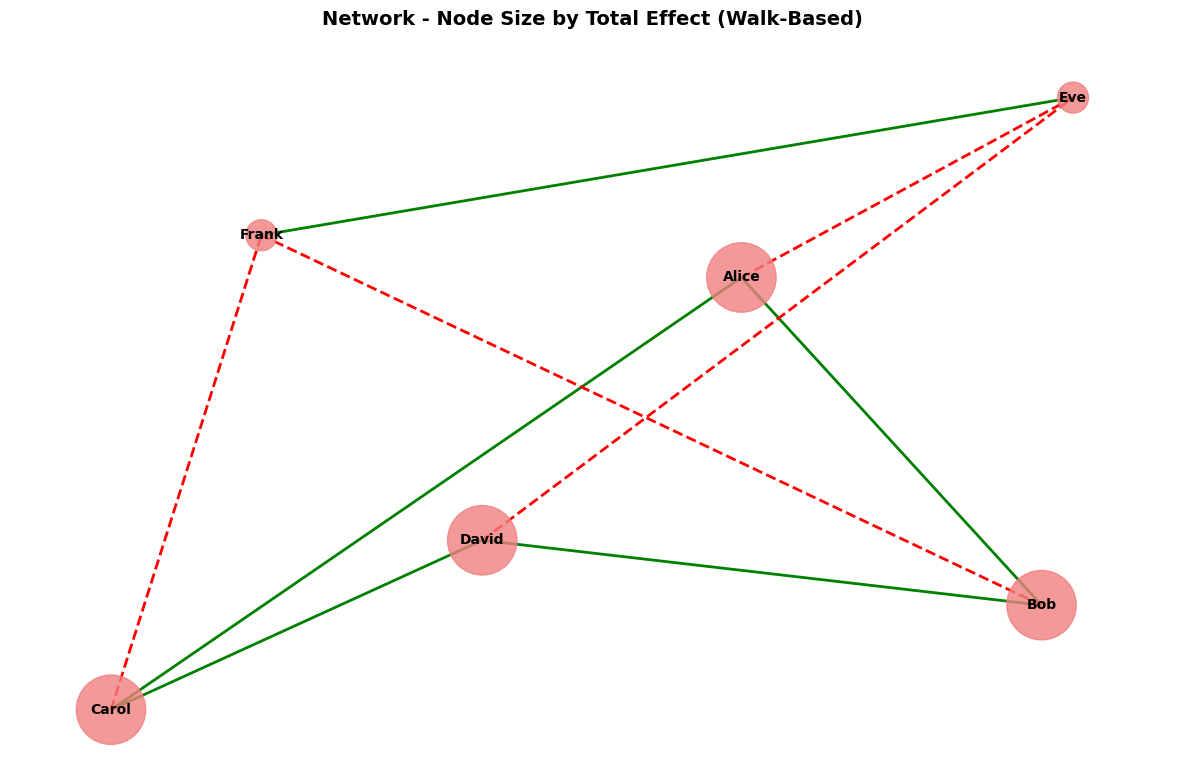

In [21]:
# Visualize walk-based total effect
visualize_centrality(G, centralities['walk_total_effect'], 
                    "Network - Node Size by Total Effect (Walk-Based)")


## PART 4: COMMUNITY DETECTION IN SIGNED NETWORKS

Community detection in signed networks seeks to find groups where:
- Internal edges are mostly **positive** (friends within groups)
- External edges are mostly **negative** (enemies between groups)

This is fundamentally different from traditional community detection which only considers positive connections.


In [22]:
def simple_signed_community_detection(G, num_communities=2):
    """
    Simple spectral clustering approach for signed networks
    """
    nodes = list(G.nodes())
    n = len(nodes)
    A = nx.adjacency_matrix(G, weight='sign').toarray()
    
    # Compute Laplacian
    D = np.diag(np.sum(np.abs(A), axis=1))
    L = D - A
    
    # Find eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    
    # Use second smallest eigenvector for 2 communities
    fiedler_vector = eigenvectors[:, 1]
    
    # Partition based on sign of Fiedler vector
    communities = {}
    for i, node in enumerate(nodes):
        communities[node] = 0 if fiedler_vector[i] < 0 else 1
    
    return communities

def analyze_community_quality(G, communities):
    """
    Analyze the quality of detected communities
    """
    internal_pos = 0
    internal_neg = 0
    external_pos = 0
    external_neg = 0
    
    for u, v, data in G.edges(data=True):
        sign = data['sign']
        same_community = (communities[u] == communities[v])
        
        if same_community:
            if sign == 1:
                internal_pos += 1
            else:
                internal_neg += 1
        else:
            if sign == 1:
                external_pos += 1
            else:
                external_neg += 1
    
    print(f"\n--- COMMUNITY QUALITY ANALYSIS ---")
    print(f"Internal positive edges: {internal_pos} (good)")
    print(f"Internal negative edges: {internal_neg} (bad)")
    print(f"External positive edges: {external_pos} (bad)")
    print(f"External negative edges: {external_neg} (good)")
    
    # Quality score
    good_edges = internal_pos + external_neg
    bad_edges = internal_neg + external_pos
    quality = good_edges / (good_edges + bad_edges) if (good_edges + bad_edges) > 0 else 0
    
    print(f"\nCommunity Quality Score: {quality:.3f}")
    return quality

def visualize_communities(G, communities):
    """Visualize network with communities colored"""
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow']
    node_colors = [colors[communities[node]] for node in G.nodes()]
    
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==1]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d['sign']==-1]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=2000, alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges,
                          edge_color='green', width=2, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, style='dashed', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("Detected Communities in Signed Network", fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


--- DETECTED COMMUNITIES ---
Community 0: ['Alice', 'Bob']
Community 1: ['Carol', 'David', 'Eve', 'Frank']

--- COMMUNITY QUALITY ANALYSIS ---
Internal positive edges: 3 (good)
Internal negative edges: 2 (bad)
External positive edges: 2 (bad)
External negative edges: 2 (good)

Community Quality Score: 0.556


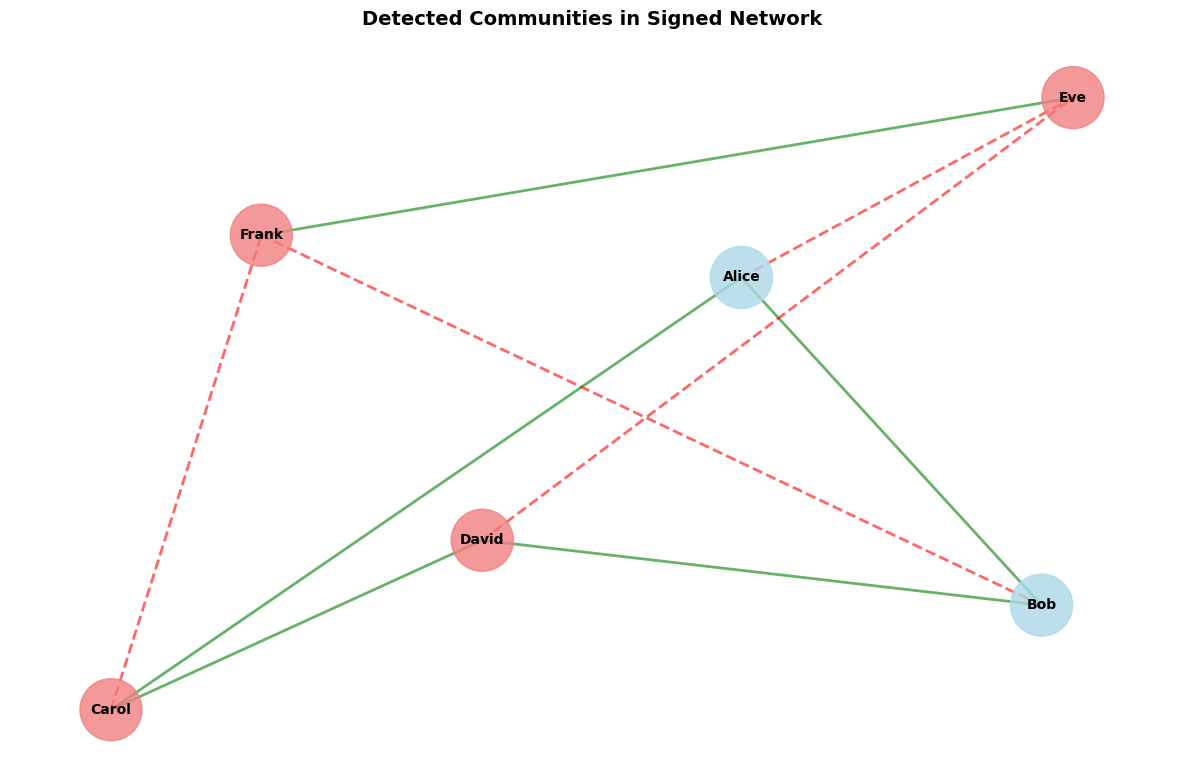

In [23]:
communities = simple_signed_community_detection(G)

print("--- DETECTED COMMUNITIES ---")
for comm_id in set(communities.values()):
    members = [node for node, c in communities.items() if c == comm_id]
    print(f"Community {comm_id}: {members}")

analyze_community_quality(G, communities)

visualize_communities(G, communities)


## PART 5: LINK PREDICTION IN SIGNED NETWORKS

Link prediction in signed networks predicts both:
- **Whether** a link will form between two nodes
- **What sign** the link will have (positive or negative)

### Principle: Structural Balance
If two nodes have common neighbors, the sign of their potential connection can be predicted based on balance theory:
- If both have the same sign to a common neighbor (+,+ or -,-) → predict **positive**
- If they have opposite signs to a common neighbor (+,- or -,+) → predict **negative**


In [24]:
def predict_edge_sign(G, node1, node2):
    """
    Predict the sign of an edge between two nodes based on balance theory
    """
    neighbors1 = set(G.neighbors(node1))
    neighbors2 = set(G.neighbors(node2))
    common_neighbors = neighbors1.intersection(neighbors2)
    
    if len(common_neighbors) == 0:
        return None, "No common neighbors for prediction"
    
    vote_positive = 0
    vote_negative = 0
    details = []
    
    for neighbor in common_neighbors:
        sign1 = G[node1][neighbor]['sign']
        sign2 = G[node2][neighbor]['sign']
        
        # For balance, if both signs are same, predict positive
        # If signs differ, predict negative
        if sign1 * sign2 == 1:
            vote_positive += 1
            prediction = "+"
        else:
            vote_negative += 1
            prediction = "-"
        
        details.append({
            'neighbor': neighbor,
            'node1_sign': '+' if sign1 == 1 else '-',
            'node2_sign': '+' if sign2 == 1 else '-',
            'prediction': prediction
        })
    
    predicted_sign = 1 if vote_positive > vote_negative else -1
    confidence = max(vote_positive, vote_negative) / (vote_positive + vote_negative)
    
    return predicted_sign, confidence, details


In [25]:
# Test link prediction
test_pairs = [('Alice', 'David'), ('Bob', 'Carol'), ('Eve', 'David')]

for node1, node2 in test_pairs:
    if not G.has_edge(node1, node2):
        sign, conf, details = predict_edge_sign(G, node1, node2)
        
        if sign is not None:
            print(f"\n--- PREDICTION: {node1} -> {node2} ---")
            print(f"Predicted sign: {'+' if sign == 1 else '-'}")
            print(f"Confidence: {conf:.2%}")
            print("\nBasis (common neighbors):")
            for d in details:
                print(f"  Via {d['neighbor']}: {node1}{d['node1_sign']} "
                      f"{d['neighbor']}{d['node2_sign']} -> predict {d['prediction']}")



--- PREDICTION: Alice -> David ---
Predicted sign: +
Confidence: 100.00%

Basis (common neighbors):
  Via Bob: Alice+ Bob+ -> predict +
  Via Carol: Alice+ Carol+ -> predict +
  Via Eve: Alice- Eve- -> predict +

--- PREDICTION: Bob -> Carol ---
Predicted sign: +
Confidence: 100.00%

Basis (common neighbors):
  Via Frank: Bob- Frank- -> predict +
  Via David: Bob+ David+ -> predict +
  Via Alice: Bob+ Alice+ -> predict +


## EXERCISES FOR PRACTICE

1. **Create your own signed network** with at least 8 nodes:
   - Model a social network with friends and enemies
   - Calculate its balance index
   - Are there any perfectly balanced subgraphs?

2. **Normalize signed degree centrality**: Modify the function to divide by the maximum possible degree.

3. **Find controversial nodes**: Implement a function to identify nodes with many both positive and negative connections.

4. **Karate Club with conflicts**: Use the Karate Club dataset, randomly assign some edges as negative, and analyze community structure.

5. **Advanced link prediction**: Use paths of length 2 (not just common neighbors) and weight predictions by evidence strength.

6. **Balance restoration**: Given an unbalanced network, suggest which edge signs should change to maximize balance index.

7. **Temporal analysis**: Create a sequence of signed networks over time, track balance index changes, and predict relationship flips.

8. **Signed PageRank**: Modify PageRank to handle negative edges - how should they affect importance propagation?


## KEY TAKEAWAYS

### Fundamental Concepts:
1. **Signed networks capture richer relationships** than unsigned networks
2. **Balance theory explains stable configurations** in social systems
3. **Centrality measures must account** for both positive and negative edges
4. **Community detection seeks groups** with internal positive and external negative edges
5. **Link prediction uses structural balance** principles
6. **Real social networks tend toward** but don't achieve perfect balance

### CRITICAL INSIGHTS FROM LITERATURE:

7. **Standard betweenness and closeness DON'T work** for signed networks!
   - They assume all paths are equally useful
   - They don't account for the meaning of negative edges
   
8. **Walk-based methods are more appropriate** for signed networks:
   - Consider ALL paths, not just shortest paths
   - Signs multiply along paths: (+)(+)=+, (+)(-)=-, (-)(-)=+
   - Separates total influence from net (signed) influence
   
9. **Different centrality measures for signed networks**:
   - **Total Effect**: Overall influence magnitude
   - **Net Effect**: Positive influence - Negative influence
   - **Signed Degree**: Positive connections - Negative connections
   
10. **Key reference**: Liu et al. (2020) "A simple approach for quantifying node centrality in signed and directed social networks"
    - https://appliednetsci.springeropen.com/articles/10.1007/s41109-020-00288-w

---

**Tutorial Complete!** Try the exercises above to deepen your understanding of signed networks.


SIGNED NETWORK ILP COMMUNITY DETECTION

### EXAMPLE 1: Simple Balanced Network ###

Network: 6 nodes, 6 positive edges, 3 negative edges
Detecting 2 communities...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/d02ed3a71e0644b483989dd9309f017d-pulp.mps -sec 60 -timeMode elapsed -branch -printingOptions all -solution /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/d02ed3a71e0644b483989dd9309f017d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 41 COLUMNS
At line 195 RHS
At line 232 BOUNDS
At line 254 ENDATA
Problem MODEL has 36 rows, 21 columns and 102 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 60
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 18

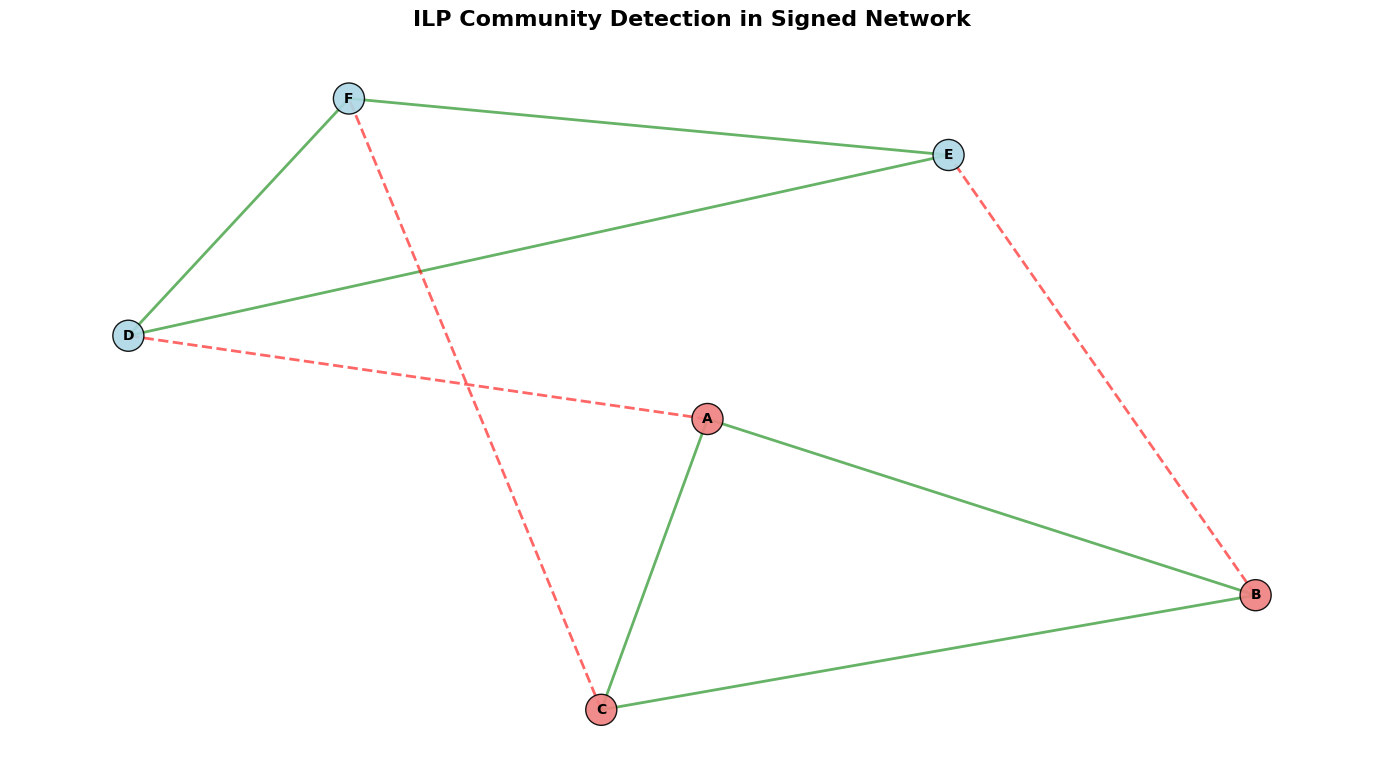



### EXAMPLE 2: Larger Network with Imbalance ###

Network: 15 nodes, 30 positive edges, 7 negative edges
Detecting 3 communities...
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/3652a020bf9c4069b6ef31f2e272cf1c-pulp.mps -sec 120 -timeMode elapsed -branch -printingOptions all -solution /var/folders/d_/2bdxdlks62s3254wmtcrd2ch0000gn/T/3652a020bf9c4069b6ef31f2e272cf1c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 221 COLUMNS
At line 1071 RHS
At line 1288 BOUNDS
At line 1371 ENDATA
Problem MODEL has 216 rows, 82 columns and 648 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 120
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0004I processed model has 216 rows, 82 columns (82 

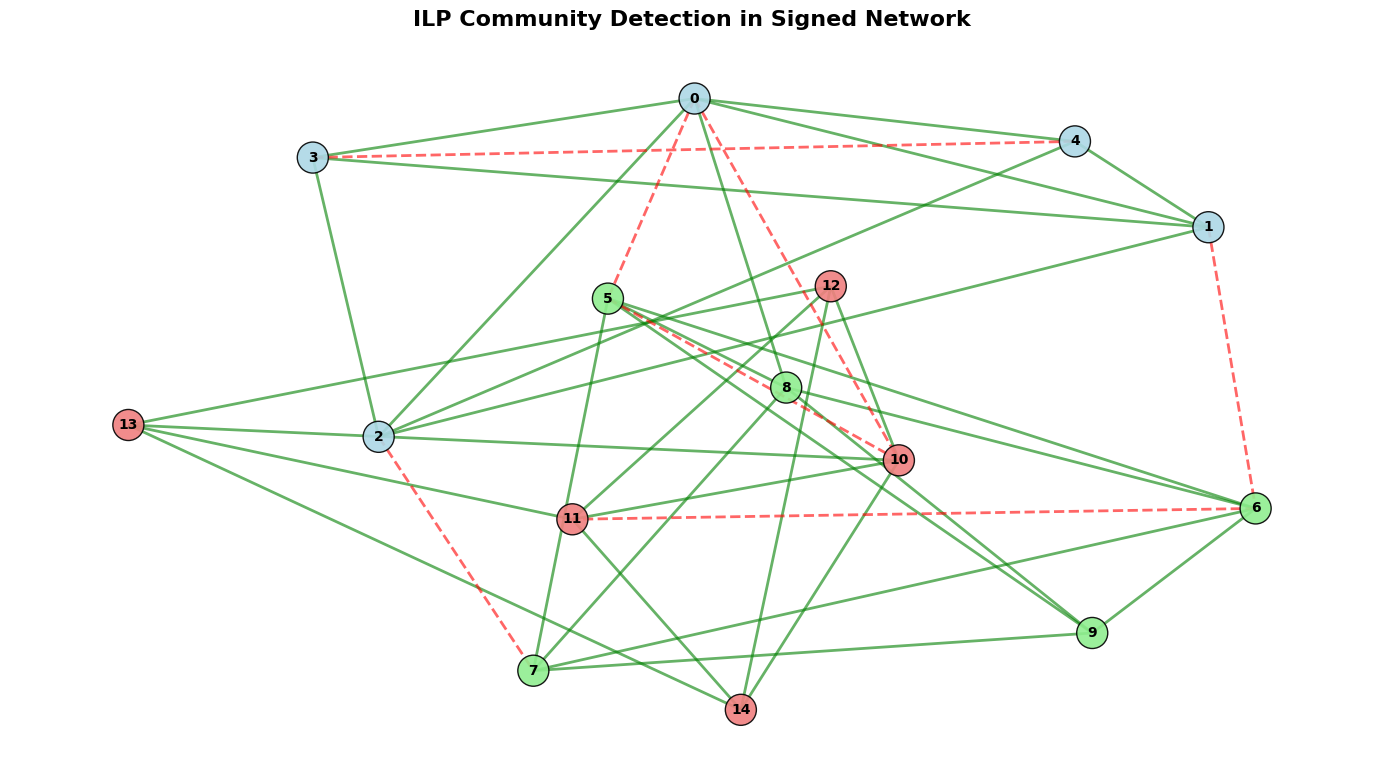


Done!


In [27]:
import networkx as nx
import numpy as np
from pulp import *

def signed_community_detection_ilp(G, num_communities, time_limit=60):
    """
    Detect communities in signed network using ILP formulation.
    
    Parameters
    ----------
    G : networkx.Graph
        Signed network with 'sign' edge attribute (+1 or -1)
    num_communities : int
        Number of communities to detect
    time_limit : int
        Maximum solving time in seconds
        
    Returns
    -------
    communities : dict
        Node to community assignment
    objective_value : float
        Number of violated edges
    status : str
        Solver status
    """
    
    # Extract nodes and edges
    nodes = list(G.nodes())
    n = len(nodes)
    communities = range(num_communities)
    
    # Separate positive and negative edges
    E_plus = []   # Positive edges (want within communities)
    E_minus = []  # Negative edges (want between communities)
    
    for u, v, data in G.edges(data=True):
        sign = data.get('sign', 1)
        if sign > 0:
            E_plus.append((u, v))
        else:
            E_minus.append((u, v))
    
    print(f"Network: {n} nodes, {len(E_plus)} positive edges, "
          f"{len(E_minus)} negative edges")
    print(f"Detecting {num_communities} communities...")
    
    # Create ILP problem
    prob = LpProblem("SignedCommunityDetection", LpMinimize)
    
    # Decision variables
    # x[i,c] = 1 if node i is in community c
    x = LpVariable.dicts("x", 
                         ((i, c) for i in nodes for c in communities),
                         cat='Binary')
    
    # f[i,j] = 1 if edge (i,j) violates the partition
    f = LpVariable.dicts("f",
                         ((i, j) for i, j in list(E_plus) + list(E_minus)),
                         cat='Binary')
    
    # Objective: Minimize total violations
    prob += lpSum([f[(i, j)] for i, j in list(E_plus) + list(E_minus)]), \
            "TotalViolations"
    
    # Constraint 1: Each node belongs to exactly one community
    for i in nodes:
        prob += lpSum([x[(i, c)] for c in communities]) == 1, \
                f"OneComm_{i}"
    
    # Constraint 2: Positive edges (want within communities)
    # f_ij >= |x_ic - x_jc| for all c
    # Since we want SAME community: f_ij >= x_ic - x_jc (if i in c, j not in c)
    for i, j in E_plus:
        for c in communities:
            prob += f[(i, j)] >= x[(i, c)] - x[(j, c)], \
                    f"PosEdge_{i}_{j}_c{c}_1"
            prob += f[(i, j)] >= x[(j, c)] - x[(i, c)], \
                    f"PosEdge_{i}_{j}_c{c}_2"
    
    # Constraint 3: Negative edges (want between communities)
    # f_ij >= x_ic + x_jc - 1 for all c
    # This is 1 when both i and j are in community c
    for i, j in E_minus:
        for c in communities:
            prob += f[(i, j)] >= x[(i, c)] + x[(j, c)] - 1, \
                    f"NegEdge_{i}_{j}_c{c}"
    
    # Solve
    solver = PULP_CBC_CMD(msg=1, timeLimit=time_limit)
    prob.solve(solver)
    
    # Extract solution
    status = LpStatus[prob.status]
    objective_value = value(prob.objective)
    
    # Get community assignments
    node_communities = {}
    for i in nodes:
        for c in communities:
            if value(x[(i, c)]) > 0.5:  # Binary variable is 1
                node_communities[i] = c
                break
    
    print(f"\nSolver Status: {status}")
    print(f"Objective Value (violations): {objective_value}")
    
    return node_communities, objective_value, status


def analyze_solution(G, communities):
    """
    Analyze the quality of the community detection result.
    """
    # Count edge violations
    pos_within = 0  # Positive edges within communities (good)
    pos_between = 0  # Positive edges between communities (bad - violation)
    neg_within = 0   # Negative edges within communities (bad - violation)
    neg_between = 0  # Negative edges between communities (good)
    
    for u, v, data in G.edges(data=True):
        sign = data.get('sign', 1)
        same_comm = (communities[u] == communities[v])
        
        if sign > 0:
            if same_comm:
                pos_within += 1
            else:
                pos_between += 1
        else:
            if same_comm:
                neg_within += 1
            else:
                neg_between += 1
    
    total_violations = pos_between + neg_within
    total_edges = pos_within + pos_between + neg_within + neg_between
    
    print("\n" + "="*60)
    print("SOLUTION ANALYSIS")
    print("="*60)
    print(f"\nPositive edges:")
    print(f"  Within communities: {pos_within} ✓")
    print(f"  Between communities: {pos_between} ✗ (violations)")
    print(f"\nNegative edges:")
    print(f"  Within communities: {neg_within} ✗ (violations)")
    print(f"  Between communities: {neg_between} ✓")
    print(f"\nTotal violations: {total_violations} / {total_edges} edges")
    print(f"Quality score: {(1 - total_violations/total_edges)*100:.1f}%")
    
    # Community sizes
    print(f"\nCommunity sizes:")
    comm_sizes = {}
    for node, comm in communities.items():
        comm_sizes[comm] = comm_sizes.get(comm, 0) + 1
    for comm, size in sorted(comm_sizes.items()):
        members = [n for n, c in communities.items() if c == comm]
        print(f"  Community {comm}: {size} nodes - {members[:10]}"
              f"{'...' if len(members) > 10 else ''}")


def visualize_communities(G, communities):
    """
    Visualize the signed network with communities.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(14, 8))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes by community
    colors = ['lightblue', 'lightcoral', 'lightgreen', 'lightyellow', 
              'plum', 'peachpuff']
    node_colors = [colors[communities[node] % len(colors)] for node in G.nodes()]
    
    # Separate edges
    pos_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('sign',1) > 0]
    neg_edges = [(u,v) for u,v,d in G.edges(data=True) if d.get('sign',1) < 0]
    
    # Draw
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=500, alpha=0.9, edgecolors='black')
    nx.draw_networkx_edges(G, pos, edgelist=pos_edges,
                          edge_color='green', width=2, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=neg_edges,
                          edge_color='red', width=2, style='dashed', alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("ILP Community Detection in Signed Network", 
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("SIGNED NETWORK ILP COMMUNITY DETECTION")
    print("="*60)
    
    # Example 1: Simple balanced network (2 communities)
    print("\n### EXAMPLE 1: Simple Balanced Network ###\n")
    
    G = nx.Graph()
    
    # Community 1: A, B, C (all friends)
    G.add_edges_from([
        ('A', 'B', {'sign': 1}),
        ('B', 'C', {'sign': 1}),
        ('C', 'A', {'sign': 1})
    ])
    
    # Community 2: D, E, F (all friends)
    G.add_edges_from([
        ('D', 'E', {'sign': 1}),
        ('E', 'F', {'sign': 1}),
        ('F', 'D', {'sign': 1})
    ])
    
    # Between communities (all enemies)
    G.add_edges_from([
        ('A', 'D', {'sign': -1}),
        ('B', 'E', {'sign': -1}),
        ('C', 'F', {'sign': -1})
    ])
    
    communities, obj_val, status = signed_community_detection_ilp(G, num_communities=2)
    
    if status == "Optimal":
        analyze_solution(G, communities)
        visualize_communities(G, communities)
    
    
    # Example 2: Larger network with imbalance
    print("\n\n### EXAMPLE 2: Larger Network with Imbalance ###\n")
    
    G2 = nx.Graph()
    
    # Create 3 communities with some violations
    # Community 0
    for i in range(5):
        for j in range(i+1, 5):
            G2.add_edge(i, j, sign=1)
    
    # Community 1
    for i in range(5, 10):
        for j in range(i+1, 10):
            G2.add_edge(i, j, sign=1)
    
    # Community 2
    for i in range(10, 15):
        for j in range(i+1, 15):
            G2.add_edge(i, j, sign=1)
    
    # Add some negative edges between communities
    G2.add_edge(0, 5, sign=-1)
    G2.add_edge(1, 6, sign=-1)
    G2.add_edge(2, 7, sign=-1)
    G2.add_edge(5, 10, sign=-1)
    G2.add_edge(6, 11, sign=-1)
    G2.add_edge(0, 10, sign=-1)
    
    # Add some violations
    G2.add_edge(0, 8, sign=1)   # Positive between communities (violation)
    G2.add_edge(3, 4, sign=-1)  # Negative within community (violation)
    
    communities2, obj_val2, status2 = signed_community_detection_ilp(
        G2, num_communities=3, time_limit=120
    )
    
    if status2 == "Optimal":
        analyze_solution(G2, communities2)
        visualize_communities(G2, communities2)
    
    print("\n" + "="*60)
    print("Done!")
    print("="*60)